# Honey Supply Policy 

The current Honey supply policy depends on governance to adjust a per block issuance rate. This is not ideal because it requires administrative governance to modulate the issuance rate, making it difficult for participants who do not have a controlling interest in governance to have confidence that issuance will be handled responsibly and predictably over time. 

We would like to design and implement a dynamic issuance policy that minimizes the need for governance decisions over issuance while ensuring that the system is attractive to both more passive speculators that want to understand the upper bounds of issuance as well as active contributors who want to ensure that the system can provide adequate and consistent rewards for the value they produce.  
    
For the purpose of this model we differentiate the honey supply into two buckets, the common pool and the circulating supply. We model inflows to the system as parameter to show how the system would behave when inflows exceed outflows, and we treat conviction outflows as a fixed percent rate from the common pool over time. This abstraction of conviction outflows represents a **maximum possible rate for a given parameterization of conviction voting**, though in practice the real outflow rate would tend to be much lower due to the ability for participants to support signaling proposals (eg abstain), or for proposal to recieve some support but ultimately fail to reach sufficient support to execute. Never the less, this creates an outlfow boundary, and by modulating issuance based on inflows and outflows, we can also understand it as an issuance boundary. 

## State Variables

We define three state variables, the common pool balance, the circulating supply. All of these variables are denominated in honey.  


In [1]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# List of all the state variables in the system and their initial values
genesis_states = {
    'reserve': 7473, # Current common pool balance
    'circulation': 18765, # Total honey supply minus common pool balance (26238 - 7473)
    'netflow': 0.0,
    'adjustment':0.0
}
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

# Model Params
We define some parameters which can be used to tune the behavior of issuance and distribution in the model 

In [2]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# List of all the state variables in the system and their initial values
params = {
    'outflow_rate': [0.1], # proportion of common pool funds that leave each timestep (month)
    'inflow': [0.015], # proportion of circulating supply that is moved to the common pool each timestep, used to show how burning kicks in when inflows exceed outflows while. 
    'throttle': [0.0], # maximimum proportion of the total supply that can be issued or burned in each timestep (month), using 0 will disable throttling and max issuance will be a function of the max outflow rate.
    'target_reserve_ratio': [0.1] # target ratio of common pool funds to total supply
}
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

# Timestep
We assume that each timestep in cadcad represents 1 month in real time, scaling model parameters to reflect that timescale. 

# Policies and State Update Functions

We define a supply policy and four state update fuctions. 


In [3]:
def supply_policy(params, step, sH, s):
    # first we calculate net flows
    outflow_rate = params['outflow_rate']
    outflow = s['reserve'] * outflow_rate
    netflow = params['inflow'] * s['circulation'] - outflow

    # then we calculate supply adjustments 
    reserve = s['reserve'] + netflow 
    circulation = s['circulation'] - netflow
    supply = reserve + circulation
    ratio = reserve / supply
    

    # Proportional control https://en.wikipedia.org/wiki/Proportional_control
    # corrections are made proportionally to the difference between the target and the current value

    if params['throttle'] != 0: 
        # Corrections bounded by a maximum issuance rate parameter 
        e = params['target_reserve_ratio'] - ratio
        if e < 0:
            adjustment = max(e, -params['throttle']) * supply
        else:
            adjustment = min(e, params['throttle']) * supply 
    else:
        # Corrections are unbounded, issuance is bounded by the maximum outflow rate 
        e = params['target_reserve_ratio'] - ratio 
        adjustment = e * supply 


    return ({'netflow':netflow, 'adjustment':adjustment})


def update_reserve(params, step, sH, s, _input):
    key = 'reserve'
    value = s['reserve'] + _input['netflow'] + _input['adjustment']
    return (key, value)

def update_circulation(params, step, sH, s, _input):
    key = 'circulation'
    value = s['circulation'] - _input['netflow']
    return (key, value)

def update_netflow(params, step, sH, s, _input):
    key = 'netflow'
    value =  _input['netflow']
    return (key, value)

def update_adjustment(params, step, sH, s, _input):
    key = 'adjustment'
    value =  _input['adjustment']
    return (key, value)

# Partial State Update Blocks


In [4]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# In the Partial State Update Blocks, the user specifies if state update functions will be run in series or in parallel
partial_state_update_blocks = [
    { 
        'policies': {
            'driver': supply_policy
        },
        'variables': { # The following state variables will be updated simultaneously
            'reserve': update_reserve,
            'circulation': update_circulation,
            'netflow': update_netflow,
            'adjustment': update_adjustment
        }
    }
]
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

# Simulation Configuration Parameters
Lastly, we define the number of timesteps and the number of Monte Carlo runs of the simulation. These parameters must be passed in a dictionary, in `dict_keys` `T` and `N`, respectively. In our example, we'll run the simulation for 10 timesteps. And because we are dealing with a deterministic system, it makes no sense to have multiple Monte Carlo runs, so we set `N=1`. We'll ignore the `M` key for now and set it to an empty `dict`

In [5]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# Settings of general simulation parameters, unrelated to the system itself
# `T` is a range with the number of discrete units of time the simulation will run for;
# `N` is the number of times the simulation will be run (Monte Carlo runs)
# In this example, we'll run the simulation once (N=1) and its duration will be of 10 timesteps
# We'll cover the `M` key in a future article. For now, let's omit it
sim_config_dict = {
    'T': range(120),
    'N': 1,
    'M': params
}
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

# Putting it all together
We have defined the state variables of our system and their initial conditions, as well as the state update functions, which have been grouped in a single state update block. We have also specified the parameters of the simulation (number of timesteps and runs). We are now ready to put all those pieces together in a `Configuration` object.

In [6]:
#imported some addition utilities to help with configuration set-up
from cadCAD.configuration.utils import config_sim
from cadCAD.configuration import Experiment
from cadCAD import configs

exp = Experiment()
c = config_sim(sim_config_dict)
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# The configurations above are then packaged into a `Configuration` object
del configs[:]
exp.append_configs(initial_state=genesis_states, #dict containing variable names and initial values
                       partial_state_update_blocks=partial_state_update_blocks, #dict containing state update functions
                       sim_configs=c #preprocessed dictionaries containing simulation parameters
                      )

# Running the engine
We are now ready to run the engine with the configuration defined above. Instantiate an ExecutionMode, an ExecutionContext and an Executor objects, passing the Configuration object to the latter. Then run the `execute()` method of the Executor object, which returns the results of the experiment in the first element of a tuple.

In [7]:
%%capture
from cadCAD.engine import ExecutionMode, ExecutionContext
exec_mode = ExecutionMode()
local_mode_ctx = ExecutionContext(exec_mode.local_mode)

from cadCAD.engine import Executor

simulation = Executor(exec_context=local_mode_ctx, configs=configs) # Pass the configuration object inside an array
raw_system_events, tensor_field, sessions = simulation.execute() # The `execute()` method returns a tuple; its first elements contains the raw results


# Analyzing the results
We can now convert the raw results into a DataFrame for analysis

In [8]:
%matplotlib inline
import pandas as pd
simulation_result = pd.DataFrame(raw_system_events)
simulation_result.set_index(['subset', 'run', 'timestep', 'substep'])

reserve   circulation     netflow  \
subset run timestep substep                                          
0      1   0        0        7473.000000  18765.000000    0.000000   
           1        1        2623.800000  19230.825000 -465.825000   
           2        1        2185.462500  19204.742625   26.082375   
           3        1        2139.020513  19135.217736   69.524889   
           4        1        2127.423825  19062.091521   73.126215   
...                                  ...           ...         ...   
           116      1        1382.241362  12387.076740   47.765495   
           117      1        1376.931810  12339.494725   47.582015   
           118      1        1371.642654  12292.095485   47.399240   
           119      1        1366.373814  12244.878318   47.217167   
           120      1        1361.125213  12197.842525   47.035793   

                              adjustment  simulation  
subset run timestep substep                           
0      1   0        0           0.000000           0  
           1        1       -4383.375000           0  
           2        1        -464.419875           0  
           3        1        -115.966877           0  
           4        1         -84.722902           0  
...                                  ...         ...  
           116      1         -53.095521           0  
           117      1         -52.891567           0  
           118      1         -52.688397           0  
           119      1         -52.486007           0  
           120      1         -52.284394           0  

[121 rows x 5 columns]

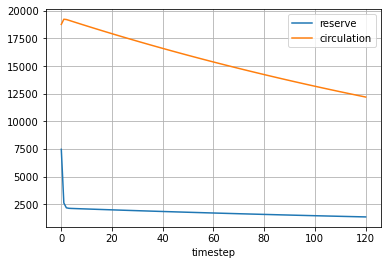

In [10]:
simulation_result.plot('timestep', ['reserve', 'circulation'], grid=True)

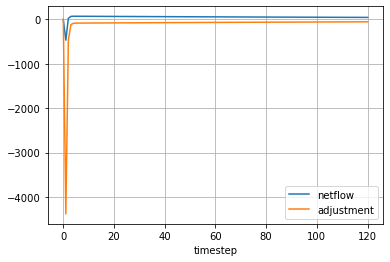

In [11]:
simulation_result.plot('timestep', ['netflow', 'adjustment'], grid=True)